In [151]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [152]:
stock1 = "GD"
stock2 = "LMT"
data = yf.download([stock1, stock2], start = "2021-06-01", end = "2026-01-10")["Close"]
data = data.dropna()

C:\Users\sidva\AppData\Local\Temp\ipykernel_33104\331874767.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([stock1, stock2], start = "2021-06-01", end = "2026-01-10")["Close"]
[*********************100%***********************]  2 of 2 completed


In [153]:
#Calculating rolling hedge ratio
window = 252
hedge_ratio = []

for i in range(window, len(data)):
    y = data[stock1].iloc[i-window:i]
    X = sm.add_constant(data[stock2].iloc[i-window:i])
    model = sm.OLS(y, X).fit()
    hedge_ratio.append(model.params[stock2])
    
hedge_ratio = pd.Series(hedge_ratio, index = data.index[window:])

#Calculating rolling spread 
spread = data[stock1].iloc[window:] - hedge_ratio.values * data[stock2].iloc[window:]

#Calculating rolling mean and std
spread_mean = spread.rolling(window).mean().shift(1)
spread_std = spread.rolling(window).std().shift(1)
zscore = (spread - spread_mean) / spread_std

In [154]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(spread.dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -3.476427736913132
p-value: 0.008613523458643869


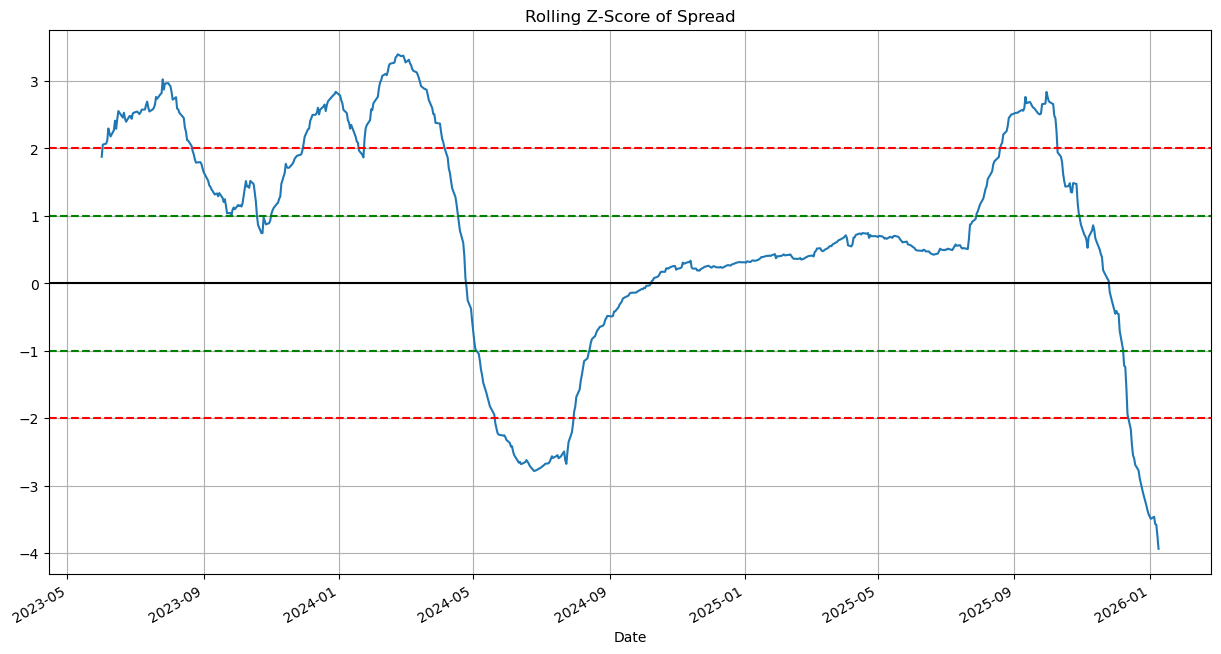

In [155]:
#Plot z-score
zscore.plot(figsize = (15, 8), title = "Rolling Z-Score of Spread")
plt.axhline(0, color = "black", label = "0")
plt.axhline(1, color = "green", linestyle = "--", label = "+1")
plt.axhline(-1, color = "green", linestyle = "--", label = "-1")
plt.axhline(2, color = "red", linestyle = "--", label = "+2")
plt.axhline(-2, color = "red", linestyle = "--", label = "-2")
plt.grid(True)
plt.show()

In [156]:
#Signals
signals = pd.DataFrame(index = zscore.index)
signals["zscore"] = zscore
signals["long_spread"] = zscore < -2.75
signals["short_spread"] = zscore > 2.75
signals["exit"] = (zscore > -0.05) & (zscore < 0.05)

position = []
current_position = 0

for i in range(len(signals)):
    if signals["long_spread"].iloc[i]:
        current_position = 1
    elif signals["short_spread"].iloc[i]:
        current_position = -1
    elif signals["exit"].iloc[i]:
        current_position = 0
        
    position.append(current_position)
    
signals["position"] = position

In [161]:
#Performance Metrics(Sharpe Ratio)
period = 252
risk_free_rate = 0.0418
strategy_returns = signals["position"].shift(1) * spread.diff()
annualized_ret = strategy_returns.mean() * period
annualized_vol = strategy_returns.std() * np.sqrt(period)
sharpe_ratio = (annualized_ret - risk_free_rate) / annualized_vol
print(f"Sharpe Ratio:", {sharpe_ratio})

Sharpe Ratio: {np.float64(2.1067737638524444)}
